The purpose of having this in a separate notebook is to avoid unneccessarily re-running the pre-processing pipeline from early_preprocessing.ipynb, and picking up with df_aus.csv and df_clean.csv.

Additional cleaning and preprocessing steps are taken here. 

The notebook uses simple TFIDF and simple ML models.

# 0. Import Data

In [59]:
import pandas as pd
import numpy as np


root_path = r'C:\Users\bened\DataScience\ANLP\AT2'
df_clean = pd.read_csv(f'{root_path}/df_clean.csv', index_col=0)
df_clean.head()

,imdbid,title,year,opening weekend,budget,age restrict,genres,screenplay,age restrict aus
0,120770,A Night at the Roxbury,1998,United States:,"$17,000,000 (estimated)","Argentina:13, Australia:M, Brazil:14, Canada:P...","Comedy, Music, Romance",\n\n\t\t\t A NIGHT AT THE ROXBURY \n\n\n\t\...,M
1,132512,At First Sight,1999,United States:,"$60,000,000 (estimated)","Argentina:13, Australia:M, Canada:PG::(Alberta...","Drama, Romance",AT FIRST SIGHT\n\nEXT. VALLEY - DUSK \nGold li...,M
2,118661,The Avengers,1998,"United States: $10,305,957, 16 Aug 1998","$60,000,000 (estimated)","Argentina:13, Australia:PG, Brazil:10, Canada:...","Action, Adventure, Sci-Fi, Thriller",\n\n\t\t\t\t\tTHE AVENGERS\n\n\t\t\t\tScreenpl...,PG
3,215545,Bamboozled,2000,United States:,"$10,000,000 (estimated)","Australia:MA, Finland:K-15, France:Tous public...","Comedy, Drama, Music",\t\t\t\tBamboozled\n\n\t\t\t\tby\n\n\t\t\t\tSp...,NaN
4,118715,The Big Lebowski,1998,"United States: $5,533,844, 08 Mar 1998","$15,000,000 (estimated)","Argentina:16, Argentina:18::(cable rating), Au...","Comedy, Crime, Sport",\n\n\t\t\tTHE BIG LEBOWSKI\n\nWe are floating ...,MA


In [67]:
df_aus = pd.read_csv(f'{root_path}/df_aus.csv', index_col=0)
df_aus.head()

,imdbid,title,year,opening weekend,budget,age restrict,genres,screenplay,age restrict aus
0,120770,A Night at the Roxbury,1998,United States:,"$17,000,000 (estimated)","Argentina:13, Australia:M, Brazil:14, Canada:P...","Comedy, Music, Romance",\n\n\t\t\t A NIGHT AT THE ROXBURY \n\n\n\t\...,M
1,132512,At First Sight,1999,United States:,"$60,000,000 (estimated)","Argentina:13, Australia:M, Canada:PG::(Alberta...","Drama, Romance",AT FIRST SIGHT\n\nEXT. VALLEY - DUSK \nGold li...,M
2,118661,The Avengers,1998,"United States: $10,305,957, 16 Aug 1998","$60,000,000 (estimated)","Argentina:13, Australia:PG, Brazil:10, Canada:...","Action, Adventure, Sci-Fi, Thriller",\n\n\t\t\t\t\tTHE AVENGERS\n\n\t\t\t\tScreenpl...,PG
4,118715,The Big Lebowski,1998,"United States: $5,533,844, 08 Mar 1998","$15,000,000 (estimated)","Argentina:16, Argentina:18::(cable rating), Au...","Comedy, Crime, Sport",\n\n\t\t\tTHE BIG LEBOWSKI\n\nWe are floating ...,MA
5,112571,Boys on the Side,1995,NaN,NaN,"Argentina:13, Australia:MA, Canada:14A::(Manit...","Comedy, Drama",Boys on the Side\n\nSCENE 1\n\nJANE\nThank you...,MA


In [61]:
df_aus.columns

Index(['imdbid', 'title', 'year', 'opening weekend', 'budget', 'age restrict',
       'genres', 'screenplay', 'age restrict aus'],
      dtype='object')

# Text Preprocessing

## Sentence Tokenization

<i> The Word2Vec models later on will require sentences as inputs. So, we should transform screenplays to sentences first, before cleaning? Basically we won't wnat to remove full-stops before sentence tokenizing. </i>

In [68]:
from nltk.tokenize import sent_tokenize

df_aus['screenplay_sentences'] = df_aus['screenplay'].apply(sent_tokenize)
df_aus['screenplay_sentences']

,screenplay_sentences
0,[\n\n\t\t\t A NIGHT AT THE ROXBURY \n\n\n\t...
1,"[AT FIRST SIGHT\n\nEXT., VALLEY - DUSK \nGold ..."
2,[\n\n\t\t\t\t\tTHE AVENGERS\n\n\t\t\t\tScreenp...
4,[\n\n\t\t\tTHE BIG LEBOWSKI\n\nWe are floating...
5,[Boys on the Side\n\nSCENE 1\n\nJANE\nThank yo...
...,...
2847,"[VO?, UD\n\nTWENTY PIRST CENTURY POR TRALEE\n\..."
2849,"[June 29, 1994\n\nWHILE YOU WERE SLEEPING...\n..."
2850,[WIND RIVER\n\nWritten by\n\nTaylor Sheridan\n...
2851,[WRONGFULLY ACCUSED\n\nBy\n\nPat Proft\n\nPROF...


## Cleaning

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # convert to lower case
    text = re.sub(r'[^\w]', ' ', text)  # remove anything that is not a word char
    text = re.sub(r'[ ]{2,}', ' ', text) # remove extra spaces
    text = re.sub(r'[ \t]+$', '', text) # remove trailing whitespace
    return text

RegEx Notes:
- ^ inside [] negates the set
- {} quantifies the preceding character. So {2,} means "2 or more" of the preceding character.
- $ anchors an expression to the end of a line or string

In [ ]:
df_clean.columns

Index(['Unnamed: 0', 'imdbid', 'title', 'year', 'opening weekend', 'budget',
       'age restrict', 'genres', 'screenplay', 'age restrict aus'],
      dtype='object')

In [54]:
df_aus.loc[:,'cleaned_screenplays'] = df_aus['screenplay'].apply(clean_text)
df_aus['cleaned_screenplays']

,cleaned_screenplays
0,a night at the roxbury written by steve koren...
1,at first sight ext valley dusk gold light dapp...
2,the avengers screenplay by don macpherson jun...
3,the big lebowski we are floating up a steep s...
4,boys on the side scene 1 jane thank you i m ja...
...,...
1886,vo ud twenty pirst century por tralee wreeten ...
1887,june 29 1994 while you were sleeping by dan su...
1888,wind river written by taylor sheridan open on ...
1889,wrongfully accused by pat proft proft things i...


## Stopword Removal

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words("english")

def remove_stopwords(text):
    processed_tokens = []
    for t in text.split():
        if t not in stop_words:
            processed_tokens.append(t)
    return " ".join(processed_tokens)

In [55]:
df_aus.loc[:,'cleaned_screenplays'] = df_aus['cleaned_screenplays'].apply(remove_stopwords)
df_aus['cleaned_screenplays'].head()

,cleaned_screenplays
0,night roxbury written steve koren ferrell chri...
1,first sight ext valley dusk gold light dapplin...
2,avengers screenplay macpherson june 21 1995 1b...
3,big lebowski floating steep scrubby slope hear...
4,boys side scene 1 jane thank jane deluca johnn...


## Stemming

In [ ]:
from nltk.stem import SnowballStemmer

In [ ]:
def stem(text):
    stemmed_tokens = []
    stemmer = SnowballStemmer("english")
    for t in text.split():
        t = stemmer.stem(t)
        stemmed_tokens.append(t)
    return " ".join(stemmed_tokens)

In [ ]:
df_clean.columns

Index(['Unnamed: 0', 'imdbid', 'title', 'year', 'opening weekend', 'budget',
       'age restrict', 'genres', 'screenplay', 'age restrict aus',
       'cleaned_screenplays'],
      dtype='object')

In [ ]:
df_clean.loc[:,'cleaned_screenplays'] = df_clean['cleaned_screenplays'].apply(stem)
df_clean['cleaned_screenplays']

,cleaned_screenplays
0,night roxburi written steve koren ferrel chris...
1,first sight ext valley dusk gold light dappl a...
2,aveng screenplay macpherson june 21 1995 1blue...
3,bamboozl spike lee black screen hear voic malc...
4,big lebowski float steep scrubbi slope hear ma...
...,...
2519,war world screenplay josh friedman david koepp...
2520,june 29 1994 sleep dan sullivan fred lebow ext...
2521,wind river written taylor sheridan open snow c...
2522,wrong accus pat proft proft thing intern revis...


In [ ]:
df_clean['age restrict aus'].value_counts()

,count
age restrict aus,
M,877
PG,335
MA15+,314
MA,173
R,103
G,89


If we narrow scope to Aus classifications for now, we have 6 target classes

## Lemmatization

In [56]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
def lemmatize(text, allowed_postags=["NOUN", "ADJ", "VERB", "INTJ", "ADV"]):
  doc = nlp(text)
  lemmas = []
  for t in doc:
    if t.pos_ in allowed_postags:
      lemmas.append(t.lemma_)
  return lemmas

df_aus['']

# Feature and Target Engineering

Encode Target (Aus ratings)

In [ ]:
aus_target_map = {
    'G': 0,
    'PG': 1,
    'M': 2,
    'MA': 3,
    'MA15+': 4,
    'R': 5
}

y = df_aus['age restrict aus'].map(aus_target_map)
y.value_counts()

,count
age restrict aus,
2,877
1,335
4,314
3,173
5,103
0,89


In [ ]:
def compute_class_balance(y):
    classes = sorted(list(y.unique()))
    value_counts = y.value_counts()
    for c in classes:
        class_ratio = value_counts[c] / len(y) * 100
        print(f"{c} represents {class_ratio}% of target data")

In [ ]:
compute_class_balance(y)

0 represents 4.706504494976203% of target data
1 represents 17.715494447382337% of target data
2 represents 46.37757800105764% of target data
3 represents 9.148598625066102% of target data
4 represents 16.604970914859862% of target data
5 represents 5.4468535166578524% of target data


There is a significant class imbalance with regard to movies rated M (3); the other imbalances are less significant.

In [ ]:
X = df_aus['screenplay'].apply(clean_text)
X = X.apply(remove_stopwords)
X = X.apply(stem)
X

,screenplay
0,night roxburi written steve koren ferrel chris...
1,first sight ext valley dusk gold light dappl a...
2,aveng screenplay macpherson june 21 1995 1blue...
3,big lebowski float steep scrubbi slope hear ma...
4,boy side scene 1 jane thank jane deluca johnni...
...,...
1886,vo ud twenti pirst centuri por trale wreeten b...
1887,june 29 1994 sleep dan sullivan fred lebow ext...
1888,wind river written taylor sheridan open snow c...
1889,wrong accus pat proft proft thing intern revis...


In [ ]:
X.to_csv("X_screenplays.csv")

In [ ]:
y.to_csv("y_austargets.csv")

# Data Split

### Splitting by 'year'

In [ ]:
df_aus['year'].describe()

,year
count,1891.000000
mean,1997.916446
std,16.889852
min,1922.000000
25%,1991.000000
50%,2001.000000
75%,2010.000000
max,2021.000000


The most recent 25% of the data comes from 2010 onwards.  We will take this as test data in the hopes our model will still work in classifying the most recent films.

In [ ]:
test_index = df_aus.loc[df_aus['year'] > 2010].index
test_index

Index([  35,   37,   38,   39,   40,   41,   42,   43,   74,   81,
       ...
       1878, 1879, 1880, 1882, 1883, 1884, 1885, 1886, 1888, 1890],
      dtype='int64', length=420)

In [ ]:
test_ratio = len(test_index) / len(df_aus.index)
print(f"Films released after 2010 (data reserved for testing) represent {test_ratio} of the dataset")

Films released after 2010 (data reserved for testing) represent 0.222104706504495 of the dataset


In [ ]:
from sklearn.model_selection import train_test_split

X_test = X.loc[test_index]
y_test = y.loc[test_index]

X_data = X.loc[~X.index.isin(test_index)]
y_data = y.loc[~y.index.isin(test_index)]

# randomized split for train-val
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

compute_class_balance(y_train)
compute_class_balance(y_val)
compute_class_balance(y_test)

0 represents 5.697278911564626% of target data
1 represents 19.472789115646258% of target data
2 represents 44.89795918367347% of target data
3 represents 12.244897959183673% of target data
4 represents 10.629251700680271% of target data
5 represents 7.0578231292517% of target data
0 represents 4.745762711864407% of target data
1 represents 20.0% of target data
2 represents 50.16949152542372% of target data
3 represents 9.830508474576272% of target data
4 represents 8.47457627118644% of target data
5 represents 6.779661016949152% of target data
0 represents 1.9047619047619049% of target data
1 represents 11.190476190476192% of target data
2 represents 47.85714285714286% of target data
4 represents 39.04761904761905% of target data


In [ ]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# TF-IDF Approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

TfidfVectorizer()

In [ ]:
# save vectorizer
from joblib import dump
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as file:
  pickle.dump(vectorizer, file)

In [ ]:
vocab = vectorizer.vocabulary_
print("Number of unique words in vocab:", len(vocab))

# sample word-value mapping
print("Sample mapping:")
for idx, element in enumerate(zip(vocab.keys(), vocab.values())):
  word, val = element
  print(f"{word} => ({val}")
  if idx == 10:
    break

Number of unique words in vocab: 220532
Sample mapping:
night => (135473
roxburi => (165133
written => (215442
steve => (184175
koren => (112876
ferrel => (76540
chris => (45941
kattan => (110273
june => (109056
1997 => (3548
fade => (74566


In [ ]:
X_tfidf_train = vectorizer.transform(X_train)
X_tfidf_val = vectorizer.transform(X_val)
X_tfidf_test = vectorizer.transform(X_test)
# print(X_tfidf_train)
# print(X_tfidf_val)
# print(X_tfidf_test)

In [ ]:
# save np arrays
np.save("X_tfidf_train.npy", X_tfidf_train)
np.save("X_tfidf_val.npy", X_tfidf_val)
np.save("X_tfidf_test.npy", X_tfidf_test)

# Traditional ML models

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

results_dict = {
    'Model Type': [],
    'Training Accuracy': [],
    'Training Recall': [],
    'Training Precision': [],
    'Training F1': [],
    'Validation Accuracy': [],
    'Validation Recall': [],
    'Validation Precision': [],
    'Validation F1': []
}

In [ ]:
def store_results(model_name, train_preds, val_preds):

  train_accuracy = accuracy_score(y_train, train_preds)
  train_precision = precision_score(y_train, train_preds, average='weighted')
  train_recall = recall_score(y_train, train_preds, average='weighted')
  train_f1 = f1_score(y_train, train_preds, average='weighted')

  val_accuracy = accuracy_score(y_val, val_preds)
  val_precision = precision_score(y_val, val_preds, average='weighted')
  val_recall = recall_score(y_val, val_preds, average='weighted')
  val_f1 = f1_score(y_val, val_preds, average='weighted')

  results_dict['Model Type'].append(model_name)
  results_dict['Training Accuracy'].append(train_accuracy)
  results_dict['Training Precision'].append(train_precision)
  results_dict['Training Recall'].append(train_recall)
  results_dict['Training F1'].append(train_f1)
  results_dict['Validation Accuracy'].append(val_accuracy)
  results_dict['Validation Precision'].append(val_precision)
  results_dict['Validation Recall'].append(val_recall)
  results_dict['Validation F1'].append(val_f1)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [ ]:
lr = LogisticRegression()
lr.fit(X_tfidf_train, y_train)
preds_train_lr = lr.predict(X_tfidf_train)
preds_val_lr = lr.predict(X_tfidf_val)

store_results("LR", preds_train_lr, preds_val_lr)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr))

Classifcation report on training data:
              precision    recall  f1-score   support

           0       1.00      0.04      0.09        67
           1       0.96      0.64      0.77       229
           2       0.52      1.00      0.69       528
           3       1.00      0.06      0.11       144
           4       1.00      0.06      0.11       125
           5       1.00      0.01      0.02        83

    accuracy                           0.59      1176
   macro avg       0.91      0.30      0.30      1176
weighted avg       0.78      0.59      0.49      1176

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.33      0.03      0.06        59
           2       0.50      0.98      0.66       148
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

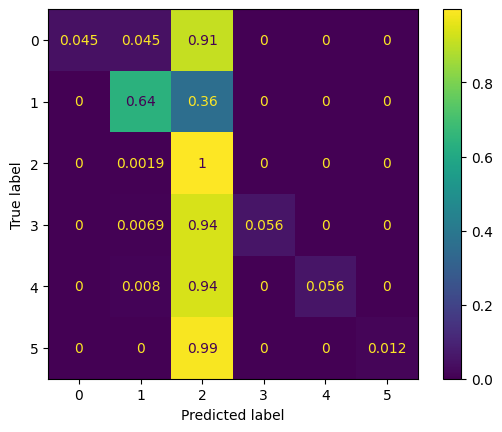

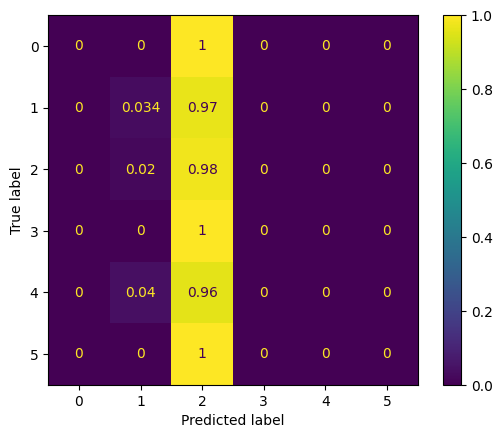

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr, normalize='true')

In [ ]:
lr_balanced = LogisticRegression(class_weight='balanced')
lr_balanced.fit(X_tfidf_train, y_train)
preds_train_lr_balanced = lr.predict(X_tfidf_train)
preds_val_lr_balanced = lr.predict(X_tfidf_val)

store_results("LR_balanced", preds_train_lr_balanced, preds_val_lr_balanced)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr_balanced))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr_balanced))

Classifcation report on training data:
              precision    recall  f1-score   support

           0       1.00      0.04      0.09        67
           1       0.96      0.64      0.77       229
           2       0.52      1.00      0.69       528
           3       1.00      0.06      0.11       144
           4       1.00      0.06      0.11       125
           5       1.00      0.01      0.02        83

    accuracy                           0.59      1176
   macro avg       0.91      0.30      0.30      1176
weighted avg       0.78      0.59      0.49      1176

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.33      0.03      0.06        59
           2       0.50      0.98      0.66       148
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

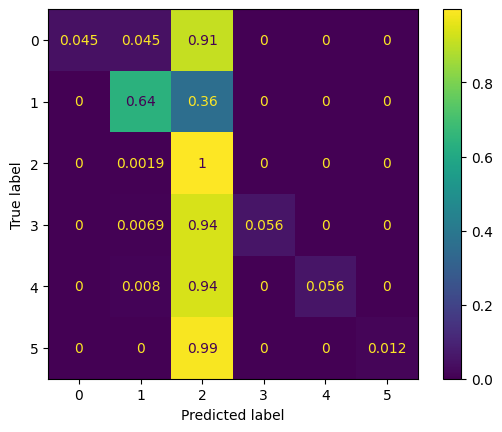

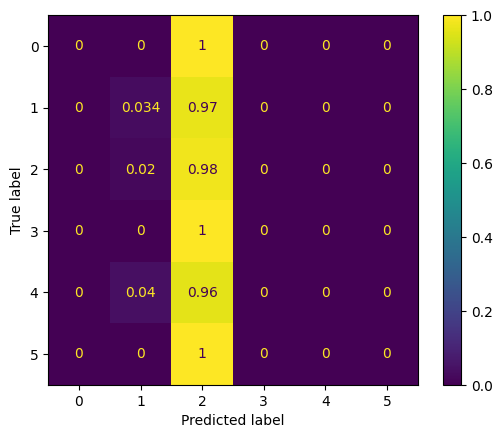

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr_balanced, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr_balanced, normalize='true')

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_tfidf_train, y_train)
preds_dt_train = dt.predict(X_tfidf_train)
preds_dt_val = dt.predict(X_tfidf_val)
print("Classification report for DT on training data:")
print(classification_report(y_train, preds_dt_train))
print("Classification report for DT on validation data:")
print(classification_report(y_val, preds_dt_val))

store_results("Decision Tree", preds_dt_train, preds_dt_val)

Classification report for DT on training data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.99      1.00      0.99       229
           2       1.00      1.00      1.00       528
           3       0.99      1.00      1.00       144
           4       1.00      1.00      1.00       125
           5       1.00      0.99      0.99        83

    accuracy                           1.00      1176
   macro avg       1.00      0.99      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Classification report for DT on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.35      0.37      0.36        59
           2       0.60      0.59      0.59       148
           3       0.20      0.28      0.23        29
           4       0.22      0.20      0.21        25
           5       0.08      0.05   

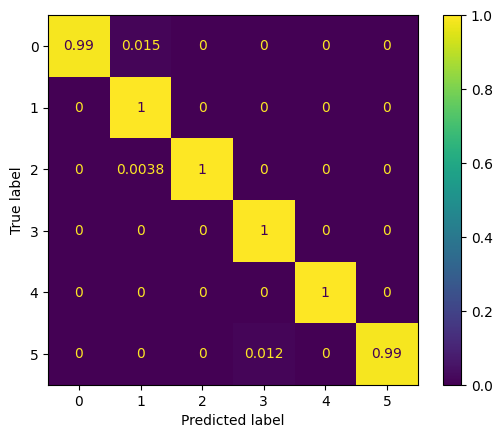

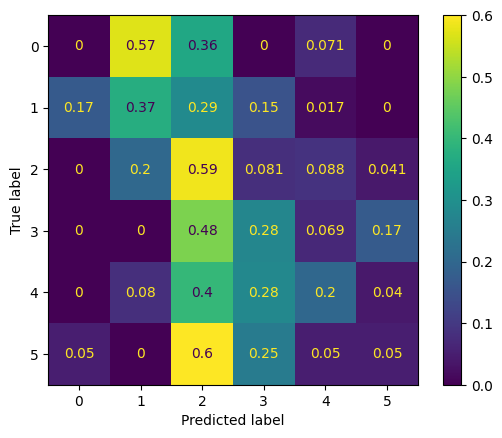

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, preds_dt_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_dt_val, normalize='true')

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_tfidf_train, y_train)
preds_svc_train = svc.predict(X_tfidf_train)
preds_svc_val = svc.predict(X_tfidf_val)
print("Classification report for SVC on training data:")
print(classification_report(y_train, preds_svc_train))
print("Classification report for SVC on validation_data:")
print(classification_report(y_val, preds_svc_val))

store_results("SVC", preds_svc_train, preds_svc_val)

Classification report for SVC on training data:
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        67
           1       0.98      0.82      0.89       229
           2       0.70      1.00      0.82       528
           3       0.98      0.76      0.85       144
           4       1.00      0.66      0.79       125
           5       1.00      0.25      0.40        83

    accuracy                           0.80      1176
   macro avg       0.94      0.63      0.70      1176
weighted avg       0.86      0.80      0.79      1176

Classification report for SVC on validation_data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.40      0.03      0.06        59
           2       0.50      0.98      0.67       148
           3       1.00      0.03      0.07        29
           4       0.00      0.00      0.00        25
           5       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

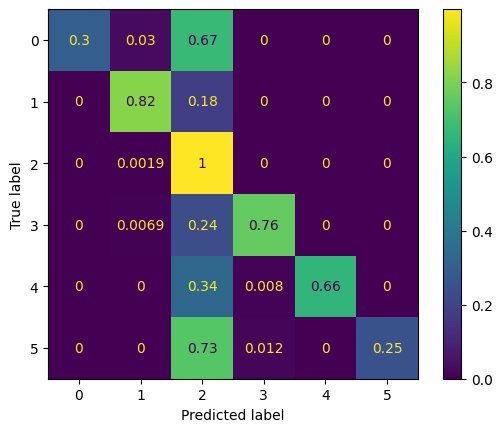

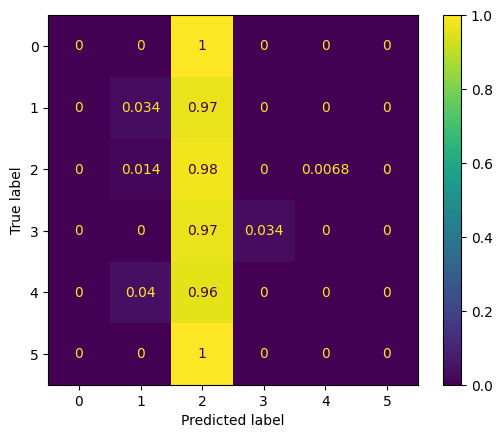

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, preds_svc_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_svc_val, normalize='true')

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict)
results_df

,Model Type,Training Accuracy,Training Recall,Training Precision,Training F1,Validation Accuracy,Validation Recall,Validation Precision,Validation F1
0,LR,0.588435,0.588435,0.778769,0.488659,0.498305,0.498305,0.318382,0.345240
1,LR_balanced,0.588435,0.588435,0.778769,0.488659,0.498305,0.498305,0.318382,0.345240
2,Decision Tree,0.996599,0.996599,0.996637,0.996601,0.416949,0.416949,0.414804,0.414896
3,SVC,0.804422,0.804422,0.859799,0.786988,0.501695,0.501695,0.430895,0.352750


In [ ]:
import gensim
from gensim.models import Word2Vec

## Continuous Bag of Words (CBOW)

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
# transform screenplays into lists of sentences
from nltk.tokenize import sent_tokenize
screenplays = df_aus['screenplay']
screenplay_sentences = df_aus['screenplay'].apply(sent_tokenize)

AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

In [49]:
sentences = list(screenplay_sentences.values)
sentences

#### Phrase Detection

I'm using gensim.models.phrases module to detect multi-word phrases with collocation statistics.  The Word2Vec model can then train on these phrases alongside unigrams, so that highly-collocated n-grams are treated as if they were single terms.  This is the approach taken by Mikolov et al. in their seminal paper on word vector representations, 'Distributed Representations of Words and Phrases and their Compositionality'.

In [51]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

phrases = Phrases(
    sentences=sentences,
    min_count=1,
    connector_words=ENGLISH_CONNECTOR_WORDS
)

screenplay_phrases_dict = phrases.export_phrases()

ValueError: Shape of passed values is (33651, 1), indices imply (33651, 2)

In [52]:
screenplay_phrases_dict

{'No?_Yes?': 626.7230582058014,
 'CUT TO: \n\n\n   EXT._SUNSET BLVD.': 63145.38064516129,
 'Good-bye._She hangs up.': 949.8771350931677,
 'Catch you later._INT.': 28.281458407979752,
 'Benny!_Benny!': 1223441.75,
 'No._No.': 265.6975757487476,
 'INTERCOM (V.O.)_No.': 625.7213911264545,
 'Yes!_No!': 139.0064100136343,
 'FADE OUT._THE END': 4236.80583686792,
 'EXT._BEAR MTN.': 20.643971559402754,
 'INT._BEAR MTN.': 50.278148280852896,
 'VOICE (O.S.)_Hello?': 77.1005868683288,
 '._?': 84.48302503976745,
 "It's an emergency._INT.": 18.854305605319833,
 'A 360 degree pan reveals: nothing._Deserted, no hiding places.': 2446883.5,
 'Silence._Only the wind over the plain.': 2566.212375458836,
 'Buckled._Strap at ankle.': 2446883.5,
 'Strap at ankle._Crunching into the ground.': 2446883.5,
 'She locks up at clouds in the sky._Then steps across to the phone box.': 2446883.5,
 'VOICE (V.O.)_(filtered)\n\t\t\tPassword affirmative.': 48453.13861386139,
 '(filtered)\n\t\t\tPassword affirmative._Than

Clearly major problems with the preprocessing approach here! We have not by any means removed non-word chars. Back to the drawing board then!

In [ ]:
# if phrasing seems appropriate, freeze the phrases model to avoid retraining
frozen_phrases = phrases.freeze()

###

In [50]:
help(gensim.models.Word2Vec)

Help on class Word2Vec in module gensim.models.word2vec:

class Word2Vec(gensim.utils.SaveLoad)
 |  Word2Vec(sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)
 |  
 |  Method resolution order:
 |      Word2Vec
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=100

In [ ]:
cbow_model = gensim.models.Word2Vec(
    sentences=frozen_phrases[sentences],
    vector_size=64,
    window=5,
    sg=0  # set sg to 0 for CBOW; 1 for skip-gram
)